In this notebook, I explore the story data and metadata. 

In [1]:
import numpy as np
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from wordcloud import WordCloud
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib notebook

In [2]:
data = pd.read_pickle('files/creep.pkl')

In [3]:
# check the metadata
data.head(10)

,title,date,subgenre,rating,time,author,polarity,subjectivity,title_length,subgenre_count,num_words,mean_word_freq,num_unique_words,unique_ratio
0,blood magic,2020-07-24,beings entities monsters creatures cryptids ...,8.15,8,Tobias Wade,0.046569,0.501569,2,10,966,0.001789,559,0.578675
1,a diner open 25 hours a day,2020-07-23,abductions kidnappings beings entities scien...,8.08,12,Christopher Maxim,0.033834,0.514034,7,7,1369,0.001193,838,0.612126
2,a shattered life,2020-07-22,madness paranoia mental illness monsters crea...,9.10,14,Matt Dymerski,0.054970,0.531194,3,10,1496,0.001259,794,0.530749
3,always be nice to your neighbors,2020-07-21,deaths murders disappearances,7.45,4,Christine Druga,0.020018,0.402989,6,3,350,0.004367,229,0.654286
4,vantablack a death metal cult,2020-07-20,rites rituals,7.63,13,Christopher Maxim,0.120475,0.501398,5,2,1338,0.001477,677,0.505979
5,new england residents beware,2020-07-19,deaths murders disappearances locations site...,7.95,9,David Feuling,0.060248,0.450850,4,9,991,0.001695,590,0.595358
6,if you see this building your timeline might ...,2020-07-18,apocalyptic dystopian artifacts objects loca...,6.91,5,Christopher Maxim,0.122275,0.567651,11,9,433,0.003247,308,0.711316
7,the family spirit,2020-07-17,ghosts spirits,8.83,9,Tobias Wade,0.031499,0.501432,3,2,1025,0.001757,569,0.555122
8,oranges,2020-07-16,beings entities demons possession strange u...,8.00,18,Matt Dymerski,-0.075987,0.544106,1,6,2143,0.001034,967,0.451237
9,my dad keeps going out to the woods at night,2020-07-15,deaths murders disappearances ghosts spirits,8.02,6,Christopher Maxim,0.130168,0.509364,10,5,572,0.002967,337,0.589161


In [4]:
# Count by tokenizing
def count_words(word_string):
    word_list = nltk.word_tokenize(word_string)
    
    return len(word_list)

In [5]:
data['title_length'] = data['title'].apply(count_words)
data['subgenre_count'] = data['subgenre'].apply(count_words)

EDA for NLP tasks is facilitated by transforming the text into a document-term matrix (dtm). Using this matrix, word counts, frequencies, and word clouds are easily obtained. 

In [6]:
# remove common noise words
extras = ['like', 'just', 'said', 'im', 'didnt', 'dont', 'did', 'youre', 'youare', 'werent']
stop_words = text.ENGLISH_STOP_WORDS.union(extras)

In [7]:
stories = pd.read_pickle('files/corpus.pkl')

In [8]:
# create word count dtm
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(stories['story'])
dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
dtm.index = stories['title']

# transpose to term-document matrix for math operations
dtm = dtm.transpose()

In [9]:
# manually delete objects to conserve memory
del data_cv, stories, cv

In [10]:
# count total words in each document
data['num_words'] = dtm.sum().array

In [11]:
# calculate the mean word frequency of each document
mat = dtm.to_numpy()
div = data['num_words'].to_numpy()
freqs = mat/div
del mat, div
data['mean_word_freq'] = freqs.sum(0)/(freqs!=0).sum(0) 
del freqs

In [12]:
data['num_unique_words'] = np.count_nonzero((dtm.to_numpy()), axis=0)

In [13]:
data['unique_ratio'] = data['num_unique_words']/data['num_words']

In [14]:
# check which predictors influence story rating
data.corr().loc['rating']**2

rating              1.000000
time                0.057003
polarity            0.000193
subjectivity        0.000965
title_length        0.006230
subgenre_count      0.003101
num_words           0.006345
mean_word_freq      0.061400
num_unique_words    0.079219
unique_ratio        0.111508
Name: rating, dtype: float64

Next, 1D metadata are explored, starting with density plots for each variable.

<IPython.core.display.Javascript object>


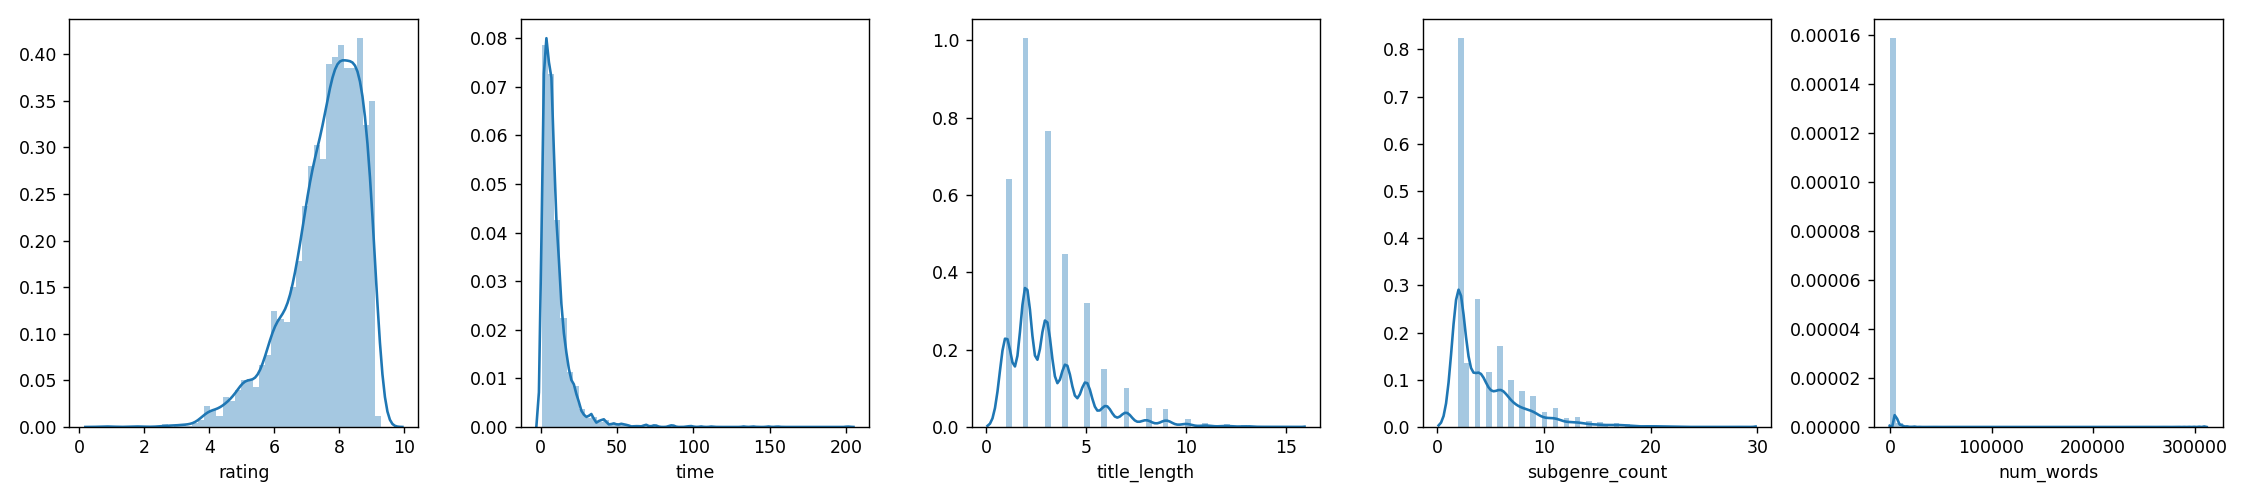

In [15]:
cols = ['rating', 'time', 'title_length', 'subgenre_count', 'num_words']

fig, axes = plt.subplots(1,5, figsize=(18,4))
for i, c in enumerate(cols):
    sns.distplot(data[c], ax=axes[i], axlabel=cols[i])
    
fig.tight_layout()

Ratings are left-skewed, while other variables are right-skewed. A small number of stories have a very large number of words. 

<IPython.core.display.Javascript object>


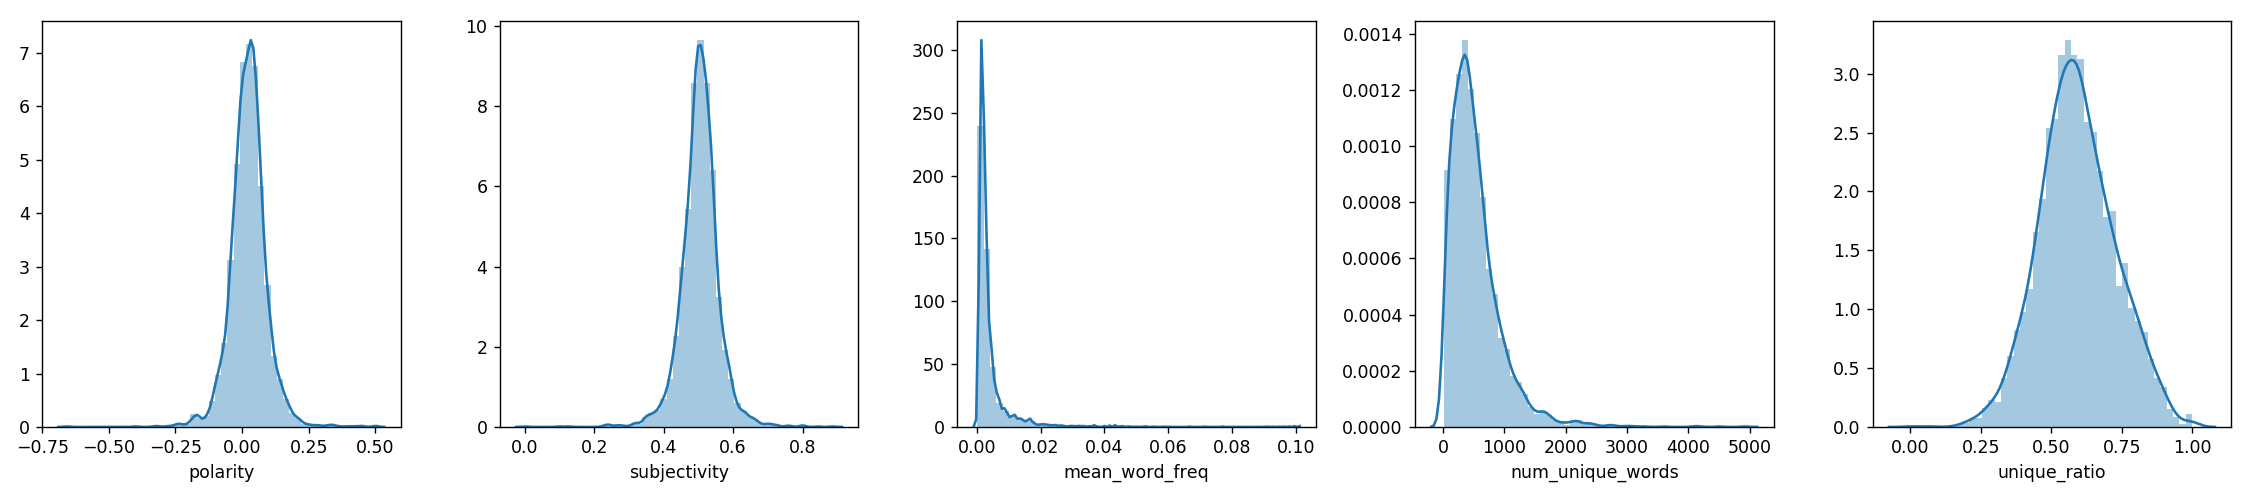

In [16]:
cols = ['polarity', 'subjectivity', 'mean_word_freq', 'num_unique_words', 'unique_ratio']

fig, axes = plt.subplots(1,5, figsize=(18,4))
for i, c in enumerate(cols):
    sns.distplot(data[c], ax=axes[i], axlabel=cols[i])
    
fig.tight_layout()

Polarity, Subjectivity, and the ratio of unique words are almost normally distributed, while mean word frequencies and numbers of unique words are right-skewed. 

Next, pairwise relations of predictors to rating are explored

<IPython.core.display.Javascript object>


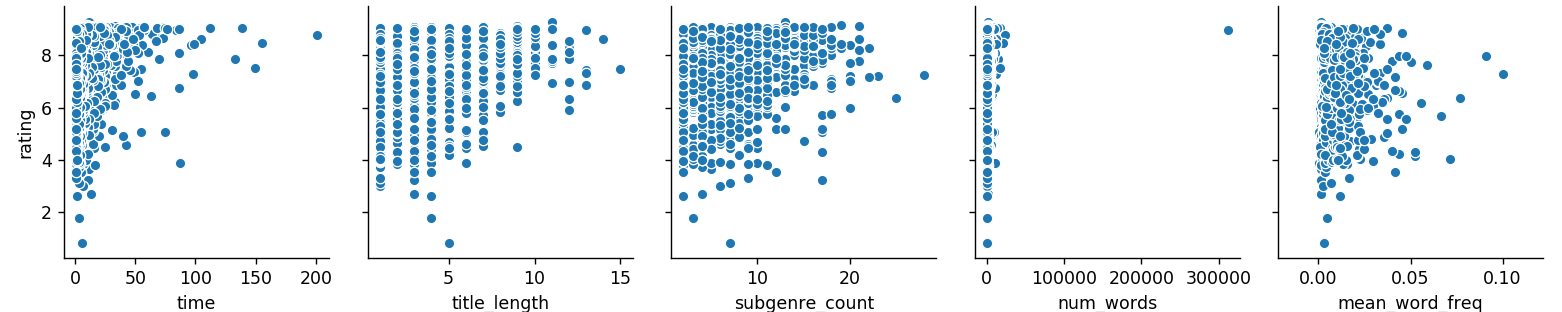

In [17]:
sns.pairplot(data, x_vars = ['time', 'title_length', 'subgenre_count', 'num_words', 'mean_word_freq'], y_vars=['rating'])

While there is some increasing relationship in this set of predictors with rating, the strength of these relations is weak.

<IPython.core.display.Javascript object>


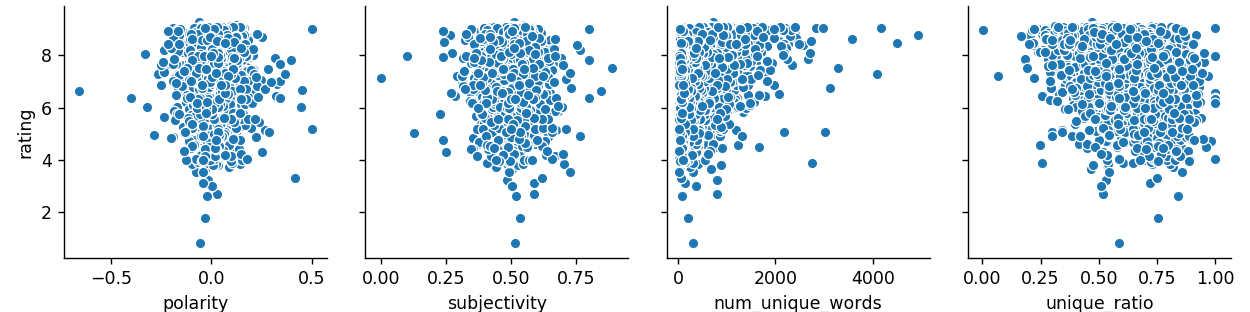

In [18]:
sns.pairplot(data, x_vars = ['polarity', 'subjectivity', 'num_unique_words', 'unique_ratio'], y_vars=['rating'])

Number of unique words seems to increase with rating, but the correlation is again weak. There is almost no correlation between rating and any of polarity, subjectivity, and unique ratio. 

Moving on, there may be some differences in the average rating by subgenre.

In [19]:
sub_list = []

# parse subgenre strings 
for s in data.subgenre:
    for word in nltk.word_tokenize(s):
        if word not in sub_list:
            sub_list.append(word)

In [20]:
# compute the mean rating by subgenre
def avg_subgenre_ratings(df, subs):
    ratings = []
    
    for sub in subs:
        temp = []
        
        for i,s in enumerate(df['subgenre']):
            if sub in s:
                temp.append(df.loc[i, 'rating'])
        
        ratings.append(np.mean(temp))
        
    return ratings        

In [21]:
rate = avg_subgenre_ratings(data, sub_list)

In [22]:
rate_frame = pd.DataFrame({'rating': rate}, index=sub_list).sort_values('rating', ascending=False)

Differences in average subgenre rating are illustrated via color gradients:

<IPython.core.display.Javascript object>


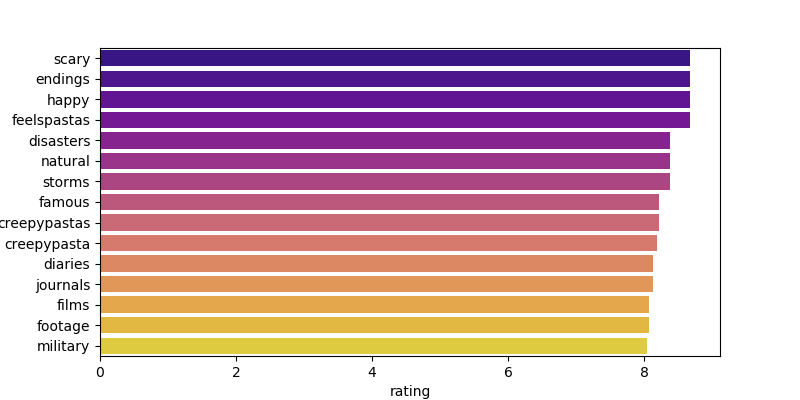

In [23]:
plt.figure(figsize=(8,4))
sns.barplot(rate_frame.rating[:15], rate_frame.index[:15], palette='plasma');

Scary stories and happy endings seem to be higher rated on average.

<IPython.core.display.Javascript object>


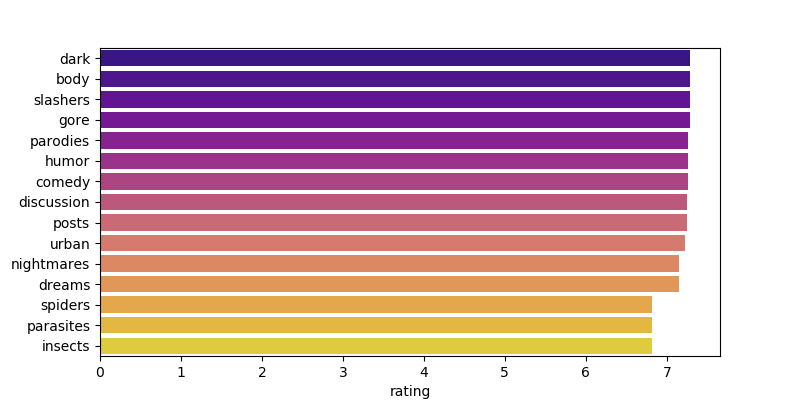

In [24]:
plt.figure(figsize=(8,4))
sns.barplot(rate_frame.rating[-15:], rate_frame.index[-15:], palette='plasma');

Stories with bugs seem to be the lowest-rated. An important limitation to this analysis to keep in mind is that the sample size of stories within a subgenre may be small. 

In [25]:
del rate_frame

In [26]:
# extract the top 15 words and their counts for each story
def top_dict(df):
    top_words = {}
    cols = df.columns
    for i in range(df.shape[1]):
        t = df.iloc[:,i].sort_values(ascending=False).head(15)
        top_words[cols[i]] = list(zip(t.index, t.values))
    
    return top_words

In [27]:
words = top_dict(dtm)

In [28]:
# get top words from the 10 best and worst-rated stories
top = list(data.sort_values(by='rating', ascending=False).head(10)['title'])
bot = list(data.sort_values(by='rating').head(10)['title'])

In [29]:
# plot word clouds for visualization 
def plot_top_words(title_list, word_dict):

    plt.rcParams['figure.figsize'] = [16, 6]
    wc = WordCloud()
    for i,s in enumerate(title_list):
        wc.generate_from_frequencies(dict(word_dict[s]))
        plt.subplot(3,4,i+1)
        plt.imshow(wc)
        plt.axis('off')
        plt.title(s)



The top 15 words in the best and worst stories are shown as word clouds:

<IPython.core.display.Javascript object>


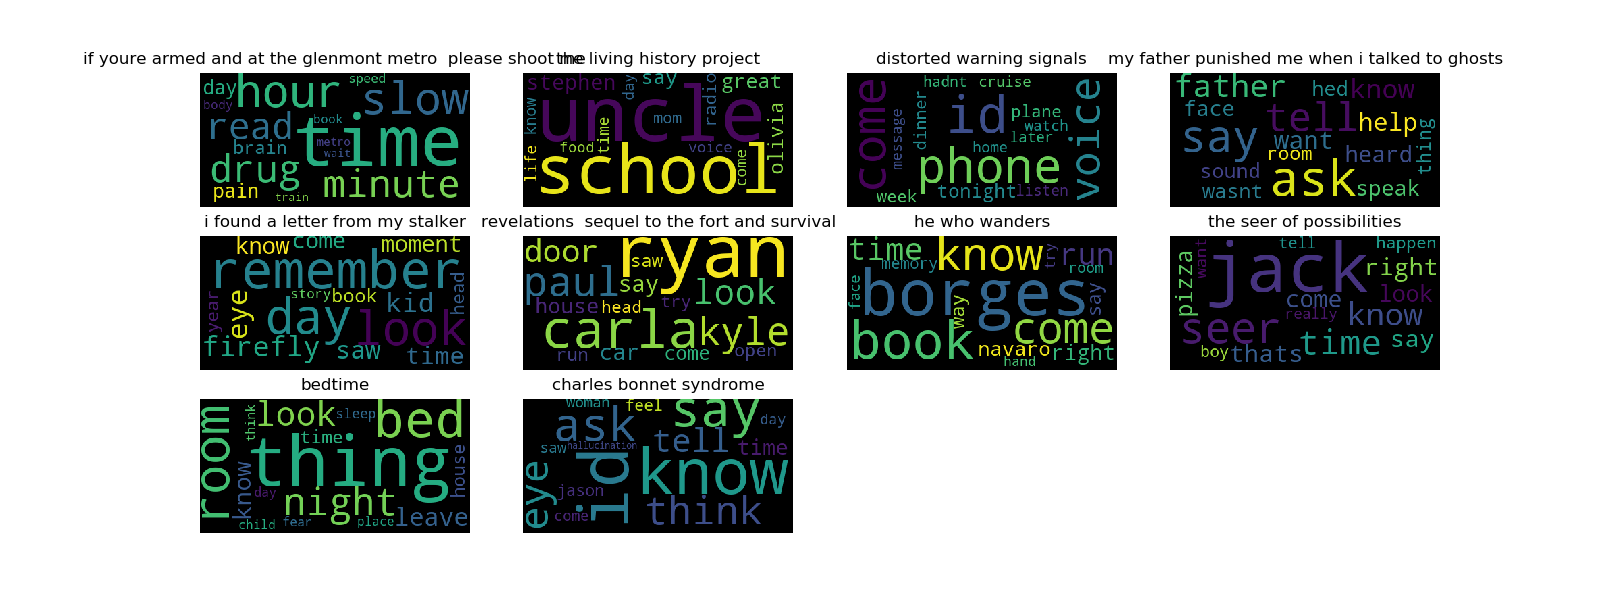

In [30]:
plot_top_words(top,words)

<IPython.core.display.Javascript object>


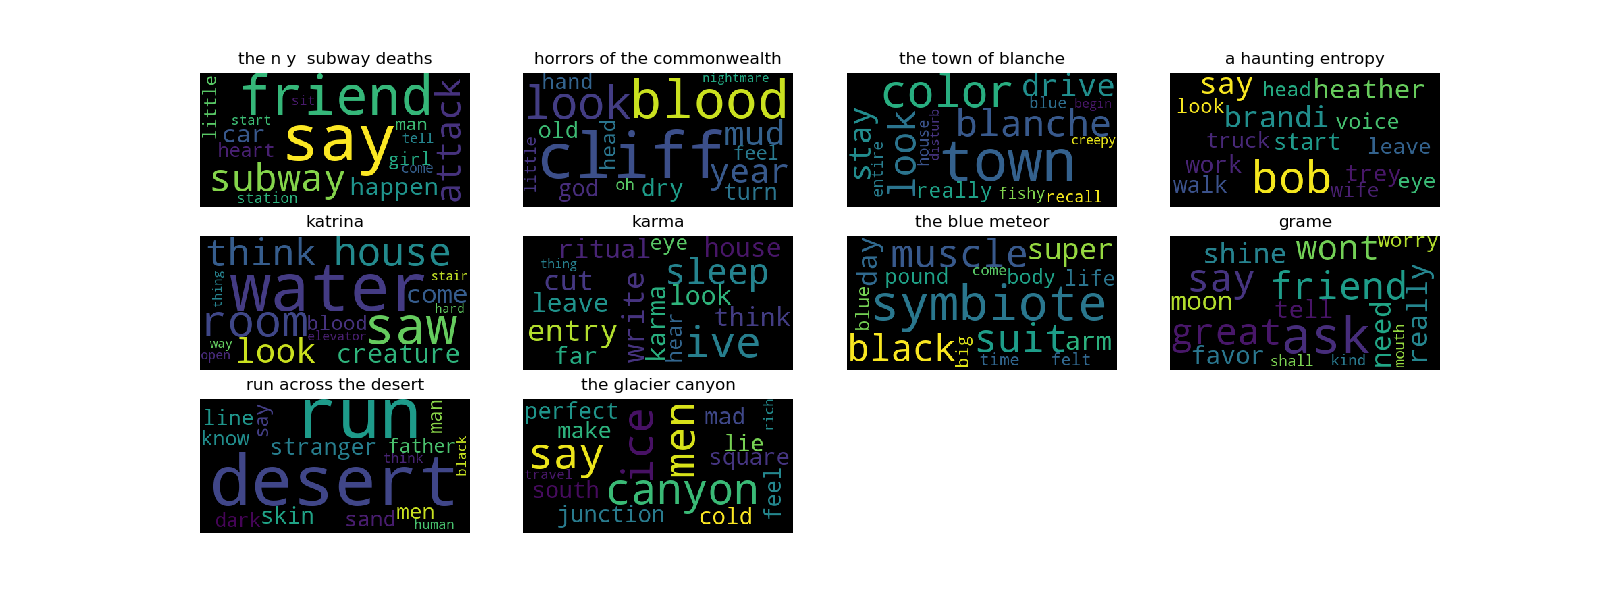

In [31]:
plot_top_words(bot,words)

In [32]:
# data.to_pickle('files/creep.pkl')